<a href="https://www.kaggle.com/code/maimunulkjisan/0-95897-loan-status-catboost-and-shap?scriptVersionId=204645840" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Loan Default Prediction using CatBoost 🌟📈💰

### Author: Maimunul Karim Jisan
### Competition Rank: 1597 out of 3858 teams

This notebook demonstrates the process of predicting loan default status using a CatBoost Classifier on the given dataset. The model goes through various preprocessing steps, hyperparameter tuning, and feature importance analysis.

---

## 📚 Table of Contents
1. [Import Libraries 📦](#import-libraries)
2. [Load Data 📥](#load-data)
3. [Preprocess Data ⚙️](#preprocess-data)
4. [Visualize Preprocessing Pipeline 🖼️](#visualize-preprocessing-pipeline)
5. [Model Training and Hyperparameter Tuning 🏋️‍♂️](#model-training-and-hyperparameter-tuning)
6. [Feature Importance 📊](#feature-importance)
7. [Prediction and Visualization 📈](#prediction-and-visualization)
8. [SHAP Values Analysis 🧪](#shap-values-analysis)

---



# 📦Import Libraries

In [1]:

import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import set_config
import matplotlib.pyplot as plt
from catboost import Pool
import seaborn as sns
import shap
import matplotlib.patches as mpatches

# 📥 Load Dataset

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
train.head()


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


# 🔢 Define Numerical and Categorical Columns

In [3]:
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade']
numerical_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']


# ✂️ Feature Engineering

In [4]:
train['cb_person_default_on_file'] = train['cb_person_default_on_file'].map({'N': 0, 'Y': 1})
test['cb_person_default_on_file'] = test['cb_person_default_on_file'].map({'N': 0, 'Y': 1})

# 📊Separating Features and Target Variable 

In [5]:
X_train = train.drop('loan_status', axis=1)
y_train = train['loan_status']

# 🧩 Preprocessing Pipelines

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features), 
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features) 
    ])
preprocessor

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['person_age', 'person_income',
                                  'person_emp_length', 'loan_amnt',
                                  'loan_int_rate', 'loan_percent_income',
                                  'cb_person_cred_hist_length']),
                                ('cat',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['person_home_ownership', 'loan_intent',
                                  'loan_grade'])])

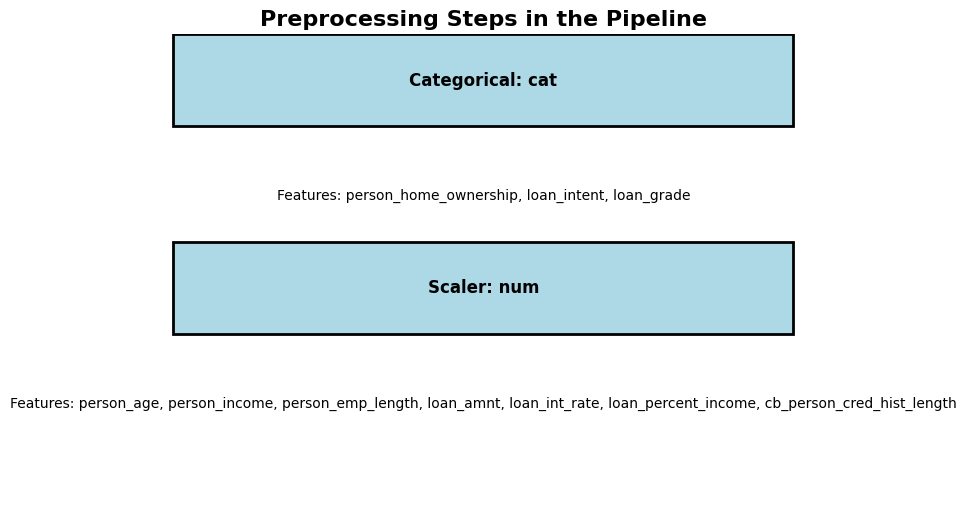

In [7]:


def draw_preprocessing_pipeline(preprocessor):
    fig, ax = plt.subplots(figsize=(10, 6))
    padding = 0.05
    rectangle_height = 0.2

    transformers_order = [
        ('Categorical', 'cat', categorical_features), 
        ('Scaler', 'num', numerical_features)
    ]
    
    for i, (name, transformer, features) in enumerate(transformers_order):
        y_position = 0.8 - i * (rectangle_height + 0.25)
        rect = mpatches.Rectangle((0.1, y_position), 0.8, rectangle_height, edgecolor='black', facecolor='lightblue', lw=2)
        ax.add_patch(rect)
        ax.text(0.5, y_position + rectangle_height / 2, f'{name}: {transformer}', 
                ha='center', va='center', fontsize=12, weight='bold')
        
        features_y_position = y_position - padding - 0.1
        ax.text(0.5, features_y_position, f'Features: {", ".join(features)}', 
                ha='center', va='center', fontsize=10)

    ax.set_title('Preprocessing Steps in the Pipeline', fontsize=16, weight='bold')
    ax.axis('off')

    plt.show()

draw_preprocessing_pipeline(preprocessor)


# 💡 Model Definition and Hyperparameter Tuning

In [8]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

catboost_model = CatBoostClassifier(loss_function='Logloss', verbose=100)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', catboost_model)
])
param_grid = {
    'classifier__iterations': [1000],
    'classifier__depth': [8],            
    'classifier__learning_rate': [0.06],  
    'classifier__l2_leaf_reg': [7]         
}
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=1, scoring='accuracy')


# 🎯 Training and Evaluation

In [9]:

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
train_accuracy = best_model.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
0:	learn: 0.6157800	total: 70.5ms	remaining: 1m 10s
100:	learn: 0.1579863	total: 1.68s	remaining: 15s
200:	learn: 0.1455970	total: 3.27s	remaining: 13s
300:	learn: 0.1346739	total: 4.99s	remaining: 11.6s
400:	learn: 0.1271653	total: 6.67s	remaining: 9.96s
500:	learn: 0.1214410	total: 8.34s	remaining: 8.31s
600:	learn: 0.1154780	total: 10s	remaining: 6.64s
700:	learn: 0.1100000	total: 11.7s	remaining: 4.99s
800:	learn: 0.1051007	total: 13.3s	remaining: 3.31s
900:	learn: 0.1005492	total: 15s	remaining: 1.65s
999:	learn: 0.0964992	total: 16.6s	remaining: 0us
Best Parameters: {'classifier__depth': 8, 'classifier__iterations': 1000, 'classifier__l2_leaf_reg': 7, 'classifier__learning_rate': 0.06}
Training Accuracy: 0.9677039815841078


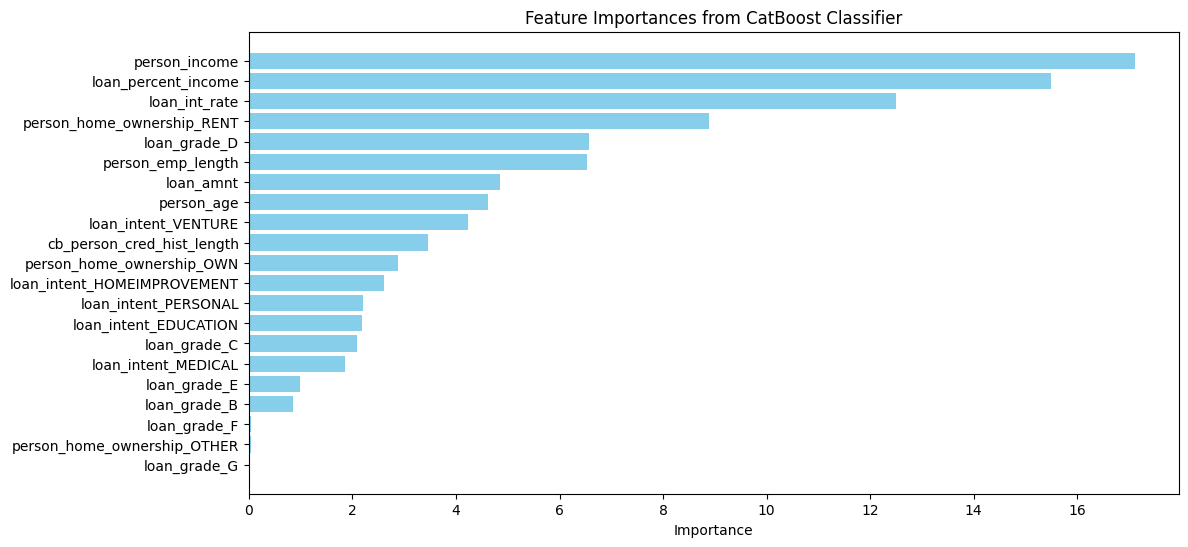

In [10]:
best_model = grid_search.best_estimator_

importances = best_model.named_steps['classifier'].get_feature_importance()

feature_names = best_model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(numerical_features).tolist() + \
                best_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features).tolist()

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from CatBoost Classifier')
plt.gca().invert_yaxis()
plt.show()

# 🛠️ Final Model Training and Prediction

In [11]:
predicted_probabilities = best_model.predict_proba(test)[:, 1]  

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


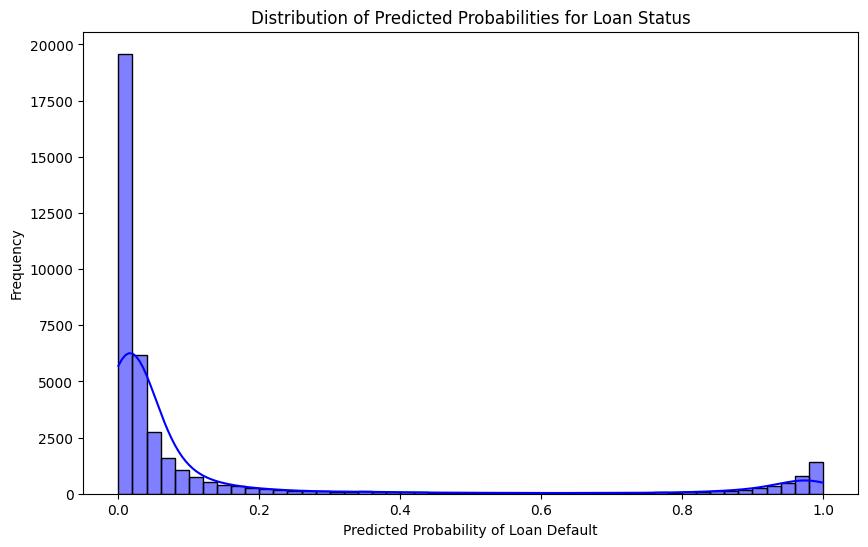

In [12]:
# Plot the distribution of predicted probabilities
plt.figure(figsize=(10, 6))
sns.histplot(predicted_probabilities, bins=50, kde=True, color='blue')
plt.title('Distribution of Predicted Probabilities for Loan Status')
plt.xlabel('Predicted Probability of Loan Default')
plt.ylabel('Frequency')
plt.show()

# 📁 Output Predictions

In [13]:
# Save predictions
output = pd.DataFrame({'id': test['id'], 'loan_status': predicted_probabilities})
output.to_csv('loan_predictions.csv', index=False)
print("Predictions saved to 'loan_predictions.csv'")


Predictions saved to 'loan_predictions.csv'


In [14]:
pd.read_csv('loan_predictions.csv')

,id,loan_status
0,58645,0.997970
1,58646,0.009895
2,58647,0.857005
3,58648,0.009934
4,58649,0.084638
...,...,...
39093,97738,0.027990
39094,97739,0.002687
39095,97740,0.004611
39096,97741,0.233367


#  📊 Shap 

(39098, 21)
[[-0.75430679  0.13060176 -0.42957619  2.83665069  1.67468729  2.18955472
  -0.94648871  0.          0.          1.          0.          1.
   0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [-0.2570553   0.84242465  0.32804728  0.14063214  0.65975036 -0.64605585
  -0.45010755  0.          0.          0.          0.          0.
   0.          1.          0.          0.          1.          0.
   0.          0.          0.        ]
 [-0.2570553  -0.89758686  0.07550612 -0.93777528  2.14590801 -0.31887001
  -0.94648871  0.          0.          1.          0.          0.
   0.          0.          1.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.9031982  -0.37031064 -0.17703503 -0.39857157 -0.58585405 -0.20980807
   0.29446419  0.          0.          1.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [-0.257

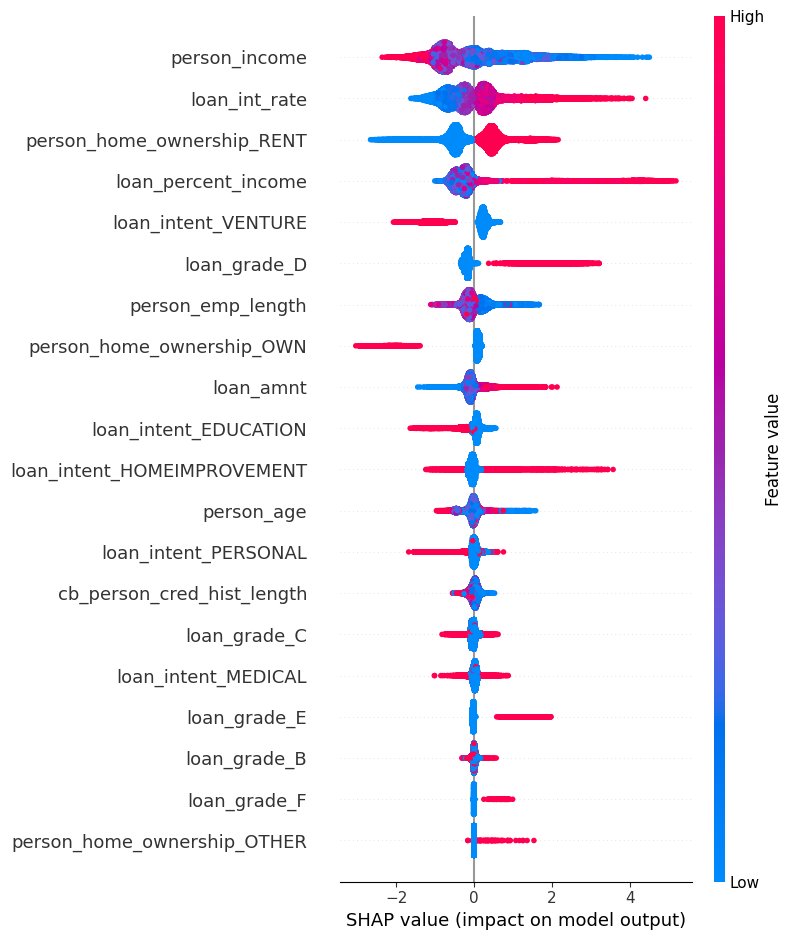

In [15]:
preprocessor.fit(X_train)

X_test_encoded = preprocessor.transform(test)

print(X_test_encoded.shape)
print(X_test_encoded[:5])

feature_names = (
    preprocessor.named_transformers_['num'].get_feature_names_out(numerical_features).tolist() +
    preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()
)

cat_features_indices = [feature_names.index(c) for c in categorical_features if c in feature_names]

X_test_pool = Pool(data=X_test_encoded, cat_features=cat_features_indices)

explainer = shap.TreeExplainer(best_model.named_steps['classifier'])

shap_values = explainer.shap_values(X_test_pool)

shap.summary_plot(shap_values, X_test_encoded, feature_names=feature_names)


# Author ✍️: Maimunul Karim Jisan

### 🎓 Education
**Graduated from:** East Delta University, Bangladesh

---

### 🌟 About Me
I am an aspiring data scientist with a strong interest in machine learning and data analysis. My passion lies in exploring innovative solutions to complex problems, and I continually strive to enhance my skills in this dynamic field.

---

### 📫 Connect with Me
- [LinkedIn Profile](https://www.linkedin.com/in/maimunul-karim-jisan-6371a7140/) 
- [GitHub Profile](https://github.com/maimunul)  

---
